In [1]:
from rdkit import Chem
import pandas as pd
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score

import seaborn as sns

In [2]:
mtor = pd.read_csv("../../data/chembl_mtor_ic50.csv", delimiter=";", usecols=["Molecule ChEMBL ID", "Smiles", "pChEMBL Value"])
mtor["mol"] = mtor.apply(lambda row: Chem.MolFromSmiles(row["Smiles"]), axis=1)
mtor["Source"] = "mtor"
mtor.rename({"Molecule ChEMBL ID":"ID"}, axis=1, inplace=True)

drugbank_mols =  Chem.SDMolSupplier('../../data/drugbank.sdf')
drugbank = [mol for mol in drugbank_mols if mol]
pd_drugbank = pd.DataFrame(drugbank, columns=["mol"])
pd_drugbank["Smiles"] = pd_drugbank.apply(lambda row: Chem.MolToSmiles(row["mol"]), axis=1)
pd_drugbank["Source"] = "drugbank"
pd_drugbank["ID"] = pd_drugbank.apply(lambda row: row["mol"].GetProp("DATABASE_ID"), axis=1)

df = pd.concat([mtor, pd_drugbank]).reset_index(drop=True)
df["c"] = df.apply(lambda row: row["mol"].HasSubstructMatch(Chem.MolFromSmarts("[#6]")), axis=1)
df = df[df["c"]].drop(columns=["c"]).reset_index(drop=True)
df.rename({"pChEMBL Value":"Activity"},axis=1, inplace=True)

[13:36:39] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:36:39] ERROR: Could not sanitize molecule ending on line 20009
[13:36:39] ERROR: Explicit valence for atom # 7 N, 4, is greater than permitted
[13:36:39] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
[13:36:39] ERROR: Could not sanitize molecule ending on line 250947
[13:36:39] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
[13:36:39] Explicit valence for atom # 17 O, 3, is greater than permitted
[13:36:39] ERROR: Could not sanitize molecule ending on line 258130
[13:36:39] ERROR: Explicit valence for atom # 17 O, 3, is greater than permitted
[13:36:39] Can't kekulize mol.  Unkekulized atoms: 57 58 59 60 61 62 63 64 65
[13:36:39] ERROR: Could not sanitize molecule ending on line 261581
[13:36:39] ERROR: Can't kekulize mol.  Unkekulized atoms: 57 58 59 60 61 62 63 64 65
[13:36:39] Explicit valence for atom # 47 Mg, 4, is greater than permitted
[13:36:39] ERROR: Could not sanitize

In [3]:
df.fillna(0, inplace=True)
data_mqn = df.join(
    pd.DataFrame(
        (rdMolDescriptors.MQNs_(mol) for mol in df["mol"]), 
        columns=[f"MQN{i}" for i in range(1,43)]))
data_vect = data_mqn.join(
    pd.DataFrame(
        (GetMorganFingerprintAsBitVect(mol, 2, 2048).ToList() for mol in df["mol"]), 
        columns=[f"{i}" for i in range(0,2048)]))

In [4]:
train, test = train_test_split(data_vect, random_state=42)

In [5]:
c = RandomForestClassifier()
c.fit(train[[f"MQN{i}" for i in range(1,43)]+[f"{i}" for i in range(0,2048)]], train["Source"])

RandomForestClassifier()

In [6]:
accuracy_score(test["Source"], c.predict(test[[f"MQN{i}" for i in range(1,43)]+[f"{i}" for i in range(0,2048)]]))

0.9900275103163686

In [7]:
knn = KNeighborsClassifier()
knn.fit(train[[f"MQN{i}" for i in range(1,43)]+[f"{i}" for i in range(0,2048)]], train["Source"])
accuracy_score(test["Source"], knn.predict(test[[f"MQN{i}" for i in range(1,43)]+[f"{i}" for i in range(0,2048)]]))

0.9632049518569463

In [8]:
df_mtor = data_vect[(data_vect["Source"] == "mtor") & (data_vect["Activity"] > 0)]
mtor_train, mtor_test = train_test_split(df_mtor, random_state=42)

In [9]:
clf = LinearRegression(n_jobs=-1)
clf.fit(mtor_train[[f"{i}" for i in range(0,2048)]], mtor_train["Activity"])

LinearRegression(n_jobs=-1)

30823134308.61544

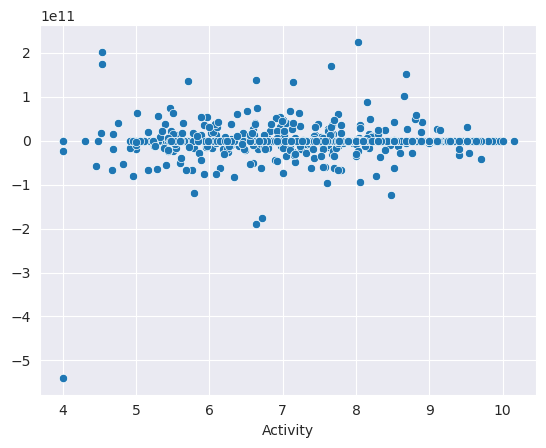

In [10]:
sns.scatterplot(x=mtor_test["Activity"], y=clf.predict(mtor_test[[f"{i}" for i in range(0,2048)]]))
root_mean_squared_error(mtor_test["Activity"],
                        clf.predict(mtor_test[[f"{i}" for i in range(0,2048)]]))

0.605006575143885

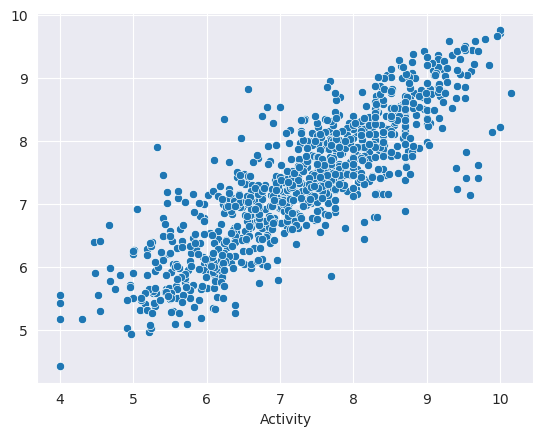

In [11]:
c = RandomForestRegressor()
c.fit(mtor_train[[f"{i}" for i in range(0,2048)]], mtor_train["Activity"])
sns.scatterplot(x=mtor_test["Activity"], y=c.predict(mtor_test[[f"{i}" for i in range(0,2048)]]))
root_mean_squared_error(mtor_test["Activity"], c.predict(mtor_test[[f"{i}" for i in range(0,2048)]]))

In [12]:
r2_score(mtor_test["Activity"], c.predict(mtor_test[[f"{i}" for i in range(0,2048)]]))

0.7340146412579425